# In this notebook a simple Q learner will be trained and evaluated. The Q learner recommends when to buy or sell shares of one particular stock, and in which quantity (in fact it determines the desired fraction of shares in the total portfolio value). One initial attempt was made to train the Q-learner with multiple processes, but it was unsuccessful.

In [6]:
# Basic imports
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.optimize as spo
import sys
from time import time
from sklearn.metrics import r2_score, median_absolute_error
from multiprocessing import Pool

%matplotlib inline

%pylab inline
pylab.rcParams['figure.figsize'] = (20.0, 10.0)

%load_ext autoreload
%autoreload 2

sys.path.append('../../')

import recommender.simulator as sim
from utils.analysis import value_eval
from recommender.agent import Agent
from functools import partial

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
NUM_THREADS = 1
LOOKBACK = -1  # 252*4 + 28
STARTING_DAYS_AHEAD = 252
POSSIBLE_FRACTIONS = [0.0, 1.0]

# Get the data
SYMBOL = 'SPY'
total_data_train_df = pd.read_pickle('../../data/data_train_val_df.pkl').stack(level='feature')
data_train_df = total_data_train_df[SYMBOL].unstack()
total_data_test_df = pd.read_pickle('../../data/data_test_df.pkl').stack(level='feature')
data_test_df = total_data_test_df[SYMBOL].unstack()
if LOOKBACK == -1:
    total_data_in_df = total_data_train_df
    data_in_df = data_train_df
else:
    data_in_df = data_train_df.iloc[-LOOKBACK:]
    total_data_in_df = total_data_train_df.loc[data_in_df.index[0]:]

# Create many agents
index = np.arange(NUM_THREADS).tolist()
env, num_states, num_actions = sim.initialize_env(total_data_in_df, 
                                                  SYMBOL, 
                                                  starting_days_ahead=STARTING_DAYS_AHEAD,
                                                  possible_fractions=POSSIBLE_FRACTIONS,
                                                  n_levels=10)
agents = [Agent(num_states=num_states, 
                num_actions=num_actions, 
                random_actions_rate=0.98, 
                random_actions_decrease=0.9999,
                dyna_iterations=0,
                name='Agent_{}'.format(i)) for i in index]

In [8]:
def show_results(results_list, data_in_df, graph=False):
    for values in results_list:
        total_value = values.sum(axis=1)
        print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(total_value))))
        print('-'*100)
        initial_date = total_value.index[0]
        compare_results = data_in_df.loc[initial_date:, 'Close'].copy()
        compare_results.name = SYMBOL
        compare_results_df = pd.DataFrame(compare_results)
        compare_results_df['portfolio'] = total_value
        std_comp_df = compare_results_df / compare_results_df.iloc[0]
        if graph:
            plt.figure()
            std_comp_df.plot()

## Let's show the symbols data, to see how good the recommender has to be.

In [9]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_in_df['Close'].iloc[STARTING_DAYS_AHEAD:]))))

Sharpe ratio: 0.4566770027925799
Cum. Ret.: 3.304502617801047
AVG_DRET: 0.0003519913231219332
STD_DRET: 0.012235538451970583
Final value: 205.54


In [10]:
# Simulate (with new envs, each time)
n_epochs = 15

for i in range(n_epochs):
    tic = time()
    env.reset(STARTING_DAYS_AHEAD)
    results_list = sim.simulate_period(total_data_in_df, 
                                       SYMBOL,
                                       agents[0],
                                       starting_days_ahead=STARTING_DAYS_AHEAD,
                                       possible_fractions=POSSIBLE_FRACTIONS,
                                       verbose=False,
                                       other_env=env)
    toc = time()
    print('Epoch: {}'.format(i))
    print('Elapsed time: {} seconds.'.format((toc-tic)))
    print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
    show_results([results_list], data_in_df)

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.39800214767456055s.  Value: 22727.87999999995..Epoch: 0
Elapsed time: 149.4782099723816 seconds.
Random Actions Rate: 0.5787243211477068
Sharpe ratio: 0.3516663920472196
Cum. Ret.: 1.280308999999995
AVG_DRET: 0.0001951932730966714
STD_DRET: 0.00881118360842108
Final value: 22803.08999999995
----------------------------------------------------------------------------------------------------
Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.3252720832824707s.  Value: 84991.8800000001....Epoch: 1
Elapsed time: 146.76813220977783 seconds.
Random Actions Rate: 0.3417569794774213
Sharpe ratio: 0.8300903771033802
Cum. Ret.: 7.427204000000012
AVG_DRET: 0.0004399503344074619
STD_DRET: 0.008413535726967344
Final value: 84272.04000000012
-----------------------

Starting simulation for agent: Agent_0. 5268 days of simulation to go.
Date 2014-12-22 00:00:00 (simulating until 2014-12-31 00:00:00).  Time: 0.2838108539581299s.  Value: 1224031.8399999999..Sharpe ratio: 2.6113451938254477
Cum. Ret.: 121.58015399999998
AVG_DRET: 0.0009290849284226412
STD_DRET: 0.005647957244281964
Final value: 1225801.5399999998
----------------------------------------------------------------------------------------------------


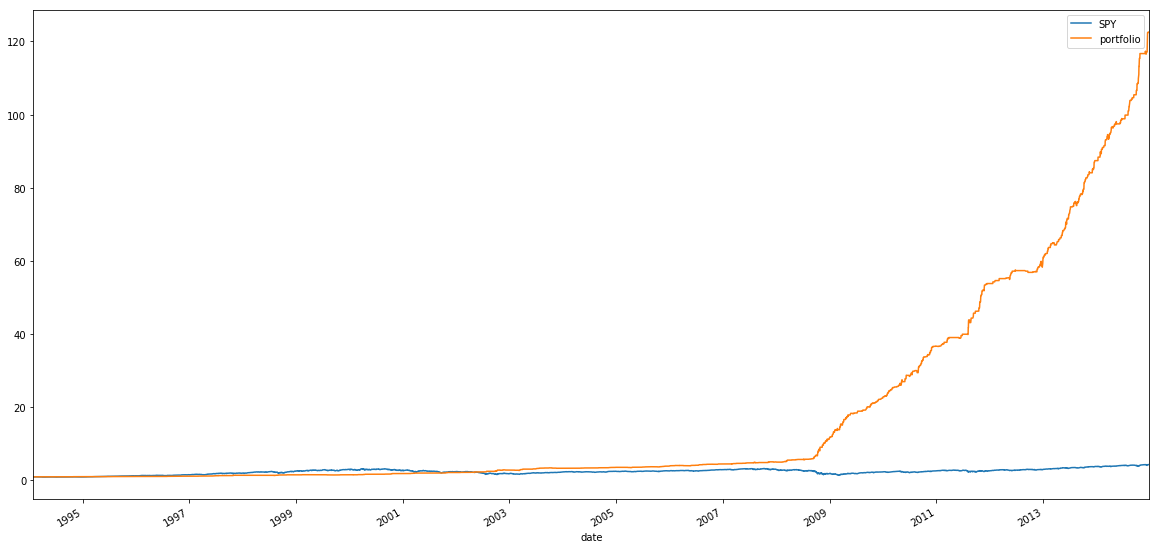

In [11]:
env.reset(STARTING_DAYS_AHEAD)
results_list = sim.simulate_period(total_data_in_df, 
                                   SYMBOL, agents[0], 
                                   learn=False, 
                                   starting_days_ahead=STARTING_DAYS_AHEAD,
                                   possible_fractions=POSSIBLE_FRACTIONS,
                                   other_env=env)
show_results([results_list], data_in_df, graph=True)

## Ok, let's save that

In [12]:
import pickle
with open('../../data/simple_q_learner_1000_states_full_training_15_epochs.pkl', 'wb') as best_agent:
    pickle.dump(agents[0], best_agent)

## Let's run the trained agent, with the test set

### First a non-learning test: this scenario would be worse than what is possible (in fact, the q-learner can learn from past samples in the test set without compromising the causality).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.17671680450439453s.  Value: 10534.740000000005.Epoch: 14
Elapsed time: 8.161107778549194 seconds.
Random Actions Rate: 0.00036300361732965325
Sharpe ratio: 0.3394029381825202
Cum. Ret.: 0.05324400000000051
AVG_DRET: 0.0001246235029780917
STD_DRET: 0.00582887345924684
Final value: 10532.440000000006
----------------------------------------------------------------------------------------------------


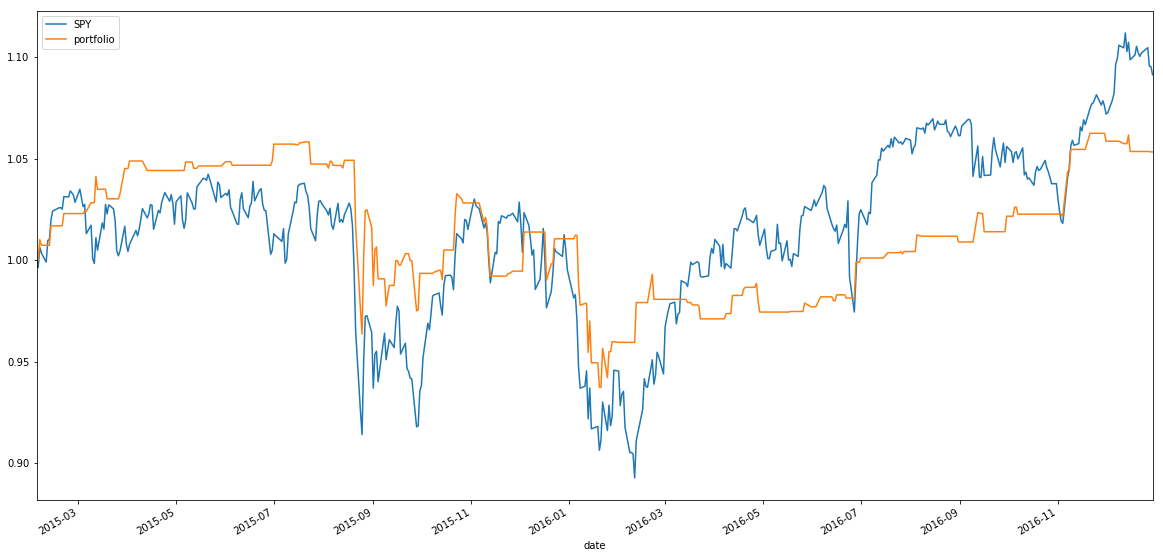

In [13]:
TEST_DAYS_AHEAD = 20

env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=False,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

### And now a "realistic" test, in which the learner continues to learn from past samples in the test set (it even makes some random moves, though very few).

Starting simulation for agent: Agent_0. 484 days of simulation to go.
Date 2016-12-28 00:00:00 (simulating until 2016-12-30 00:00:00).  Time: 0.17526507377624512s.  Value: 10043.760000000004.Epoch: 14
Elapsed time: 8.193697214126587 seconds.
Random Actions Rate: 0.00034588639540018753
Sharpe ratio: 0.06852442057274191
Cum. Ret.: 0.004156000000000271
AVG_DRET: 2.3589312742850267e-05
STD_DRET: 0.005464748589906518
Final value: 10041.560000000003
----------------------------------------------------------------------------------------------------


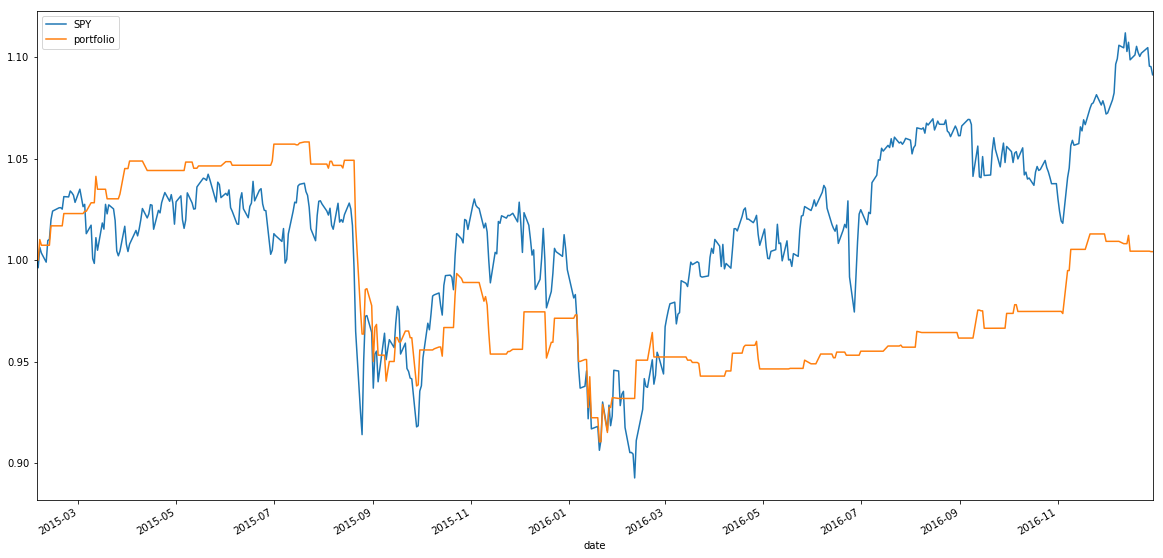

In [14]:
env.set_test_data(total_data_test_df, TEST_DAYS_AHEAD)
tic = time()
results_list = sim.simulate_period(total_data_test_df, 
                                    SYMBOL,
                                    agents[0],
                                    learn=True,
                                    starting_days_ahead=TEST_DAYS_AHEAD,
                                    possible_fractions=POSSIBLE_FRACTIONS,
                                    verbose=False,
                                    other_env=env)
toc = time()
print('Epoch: {}'.format(i))
print('Elapsed time: {} seconds.'.format((toc-tic)))
print('Random Actions Rate: {}'.format(agents[0].random_actions_rate))
show_results([results_list], data_test_df, graph=True)

## What are the metrics for "holding the position"?

In [15]:
print('Sharpe ratio: {}\nCum. Ret.: {}\nAVG_DRET: {}\nSTD_DRET: {}\nFinal value: {}'.format(*value_eval(pd.DataFrame(data_test_df['Close'].iloc[TEST_DAYS_AHEAD:]))))

Sharpe ratio: 0.44271542660031676
Cum. Ret.: 0.1070225832012679
AVG_DRET: 0.00025103195406808796
STD_DRET: 0.009001287260690292
Final value: 223.53
